*Attention U-Net Based Adversarial Architectures for Chest X-ray Lung Segmentation*\
2020 Gaal, Maga, Lukacs\
[link](https://arxiv.org/pdf/2003.10304.pdf)

# Datasets

## Some publicly available datasets

- [JSRT](https://www.ajronline.org/doi/pdf/10.2214/ajr.174.1.1740071)
	- 247 chest X-rays, 154 have lung nodules. Has lung and heart seg.
	- [Get here](http://db.jsrt.or.jp/eng.php) (register at bottom of page)
- [Montgomery and Shenzhen](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/)
	- Montgomery contains 138 chest X-rays, 80 healthy, 58 tuberculosis. Has lung seg.
	- Shenzhen contains 662 chest X-rays, 326 healthy, 336 tuberculosis. Has lung seg.
	- [Get both here](https://openi.nlm.nih.gov/faq?it=xg#collection). Look for "tuberculosis collection"

That’s 1047 images with lung segmentation label. There are larger datasets that have no segmentation label:

- [NIH ChestX-ray8](https://arxiv.org/abs/1705.02315)
	- 108,948 CXRs of 32,717 patients with eight text-mined disease labels
	- [this might be a way to download](https://nihcc.app.box.com/v/ChestXray-NIHCC)
- [NLST](https://www.nejm.org/doi/10.1056/NEJMoa1102873)
	- There's [this link](https://cdas.cancer.gov/publications/320/), which eventually leads [here](https://cdas.cancer.gov/datasets/nlst/), but I don't see any actual CXR images being made available.
 

### JSRT

See [this guide](JSRT_UsersGuide.pdf) to the data for details.

- `JPCLN***.IMG` for chest lung nodule images, and `JPCNN***.IMG` for non-nodule images. These are important classes to keep in mind for the purpose of proportional train/val/test split.
-  coordinates of the upper left of the image are `(0,0)`
- Image type: 16-bit Unsigned
- Width: 2048 pixels
- Height: 2048 pixels
- Offset to First Image: 0 bytes
- Gap Between Images: 0 bytes

You can load the images using [ImageJ](https://imagej.nih.gov/ij/).
Just import as "RAW" and put in the settings specified by the JSRT guide.

Hmm, stuck on this for now... also where are the segmentations? When I load RAW data into Image J I only see an xray image, and I see no reference to segmentation in the JSRT guide. The JSRT download page doesn't say anything about segmentation labels either.

### Shenzhen

[The readme](NLM-ChinaCXRSet-ReadMe.pdf).

- 336 cases with manifestation of tuberculosis, and 
- 326 normal cases.

- Format: PNG
- Image size varies for each X-ray. It is approximately 3K x 3K.

- Image file names are coded as `CHNCXR_#####_0/1.png`, where ‘0’ represents the normal and ‘1’
represents the abnormal lung. 

Hmm I also cannot find any lung segmentation for this. And [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/) that introduces the dataset seems to suggest that it's just the Montgomery set that has the segmentation.

### Montgomery

[The readme](NLM-MontgomeryCXRSet-ReadMe.pdf).

- 58 cases	with	manifestation	of	tuberculosis,	and	 80 normal	cases.
- Image	 file	 names	are	 coded	as	`MCUCXR_#####_0/1.png`, where	‘0’	 represents	 the	 normal	and	‘1’ represents	the	abnormal	lung. These are important classes to keep in mind for the purpose of proportional train/val/test split.

---

- Format:	PNG
- Matrix	size	is	4020	x	4892,	or	4892	x	4020.
- The	pixel	spacing	in	vertical	and	horizontal	directions	is	0.0875	mm.	
- Number	of	gray	levels	is	12 bits.

---

Segmentation:
> We	manually	generated	the	“gold	standard” segmentations	for	the	chest	X-ray	under	the	supervision	of a	radiologist.	We	used	the	following	conventions	for outlining	the	lung	boundaries:	Both	posterior	and	anterior	ribs	are	readily	visible	in	the	CXRs;	the	part	of	the	lung	behind	the	heart	is	excluded.	We	follow	anatomical	 landmarks	 such	 as	 the	 boundary	 of	 the	 heart,	 aortic	 arc/line,	 and	 pericardium	 line;	 and	sharp	costophrenic	angle	that	follow	the	diaphragm	boundary. We	draw	an	inferred	boundary	when	the	pathology	is	severe	and	affects	the	morphological	appearance	of	the	lungs. The	lung	boundaries	(left	and	right)	are	in	binary	image	format	and	have	the	same	file	name	as	chest	Xrays	( e.g.	`…/left/MCUCXR_#####_0/1.png` or	`…/right/MCUCXR_#####_0/1.png`). 

Looks like this is the one we can actually use here.

In [1]:
import os, glob

dataset_base_path = '/home/ebrahim/data/chest_xrays/MontgomerySet'
dataset_imgs_path = os.path.join(dataset_base_path, 'CXR_png/')
dataset_seg_path_left = os.path.join(dataset_base_path, 'ManualMask/leftMask')
dataset_seg_path_right = os.path.join(dataset_base_path, 'ManualMask/rightMask')

imgs = glob.glob(os.path.join(dataset_imgs_path, '*.png'))
segs_left = glob.glob(os.path.join(dataset_seg_path_left, '*.png'))
segs_right = glob.glob(os.path.join(dataset_seg_path_right, '*.png'))

file_path_to_ID = lambda p : os.path.basename(p)[7:11]
file_path_to_abnormality = lambda p : bool(int(os.path.basename(p)[12]))

img_ids = list(map(file_path_to_ID,imgs));
seg_ids_left = list(map(file_path_to_ID,segs_left));
seg_ids_right = list(map(file_path_to_ID,segs_right));

data = []
for img in imgs:
    img_id = file_path_to_ID(img)
    seg_left = segs_left[seg_ids_left.index(img_id)]
    seg_right = segs_right[seg_ids_right.index(img_id)]
    tuberculosis = file_path_to_abnormality(img)
    data.append({
        'img' : img,
        'seg_left' : seg_left,
        'seg_right' : seg_right,
        'tuberculosis' : tuberculosis

    })

In [2]:
import monai
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
data_train, data_valid = monai.data.utils.partition_dataset_classes(
    data,
    classes = list(map(lambda d : d['tuberculosis'], data)),
    ratios = (8,2)
)

In [4]:
# Custom transforms
from typing import Mapping, Hashable, List

class MasksToOneHotD(monai.transforms.MapTransform):
    def __init__(self, keys: monai.config.KeysCollection,
                 keyList: List[Hashable], newKeyName: str) -> None:
        super().__init__(keys)
        self.keyList = keyList
        self.newKeyName = newKeyName
        assert(len(keyList)>0)

    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Mapping[Hashable, np.ndarray]:
        
        # (if this were to be contributed, I'd have to pay attention to whether keys are in data)
        # (also I'd want to raise more clear exceptions than these asserts)
        
        assert(all(key in self.keys for key in self.keyList))
        assert(all(key in data.keys() for key in self.keyList))
        assert(self.newKeyName not in data.keys())
        
        background_mask = (sum(data[key] for key in self.keyList)==0).astype('int8')
        
        # Assumes these were numpy arrays.
        # If they were torch tensors we'd have to do "torch.stack" and use argument "dim" instead of "axis"
        data[self.newKeyName] = np.stack(
            [background_mask] + [data[key] for key in self.keyList],
            axis=0
        )
        
        return data


In [5]:
image_size = 512

transform_valid = monai.transforms.Compose([
    monai.transforms.LoadImageD(keys = ['img']),
    monai.transforms.LoadImageD(keys = ['seg_left', 'seg_right'], dtype="int8"),
    monai.transforms.TransposeD(keys = ['img', 'seg_left', 'seg_right'], indices = (1,0)),
    monai.transforms.AddChannelD(keys = ['img']),
    MasksToOneHotD(
        keys = ['seg_left', 'seg_right'],
        keyList = ['seg_left', 'seg_right'],
        newKeyName = 'seg'
    ),
    monai.transforms.DeleteItemsD(keys = ['seg_left', 'seg_right']),
    monai.transforms.ResizeD(keys = ['img', 'seg'], spatial_size=(image_size,image_size)),
    monai.transforms.ToTensorD(keys = ['img', 'seg']),
])

transform_train = monai.transforms.Compose([
    transform_valid,
    monai.transforms.RandRotateD(keys = ['img', 'seg'],
                                 range_x = np.pi/8,
                                 padding_mode="zeros",
                                 prob=1.,
                                 mode = ['bilinear', 'nearest'])
])

In [6]:
# TODO: switch back to CacheDataset once ready to start training

dataset_train = monai.data.CacheDataset(data_train, transform_train)
dataset_valid = monai.data.CacheDataset(data_valid, transform_valid)
# dataset_train = monai.data.Dataset(data_train, transform_train)
# dataset_valid = monai.data.Dataset(data_valid, transform_valid)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 11.82it/s]


In [7]:
dataset_train[0].keys()

dict_keys(['img', 'tuberculosis', 'img_meta_dict', 'seg_left_meta_dict', 'seg_right_meta_dict', 'img_transforms', 'seg_left_transforms', 'seg_right_transforms', 'seg', 'seg_transforms'])

# Previewing

In [8]:
def preview(data_item):
    fig = plt.figure(figsize=(7,7))
    im = data_item['img'].expand((3,)+data_item['img'].shape[1:])
    im = im/im.max()
    seg = data_item['seg'].float()
    im[1,:,:] *= 1-0.3*seg[1,:,:]
    im[2,:,:] *= 1-0.3*seg[2,:,:]
    im = np.transpose(im,axes=(1,2,0))
    plt.imshow(im, cmap='bone')
    plt.plot();

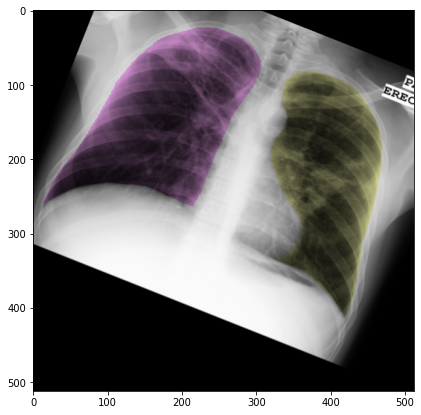

In [9]:
import random
preview(random.choice(dataset_train))

Note that some images have different original dimensions. Some are (4020, 4892) and some are (4892, 4020). 

# seg net

Structure of U-Net is inspired by this paper: https://arxiv.org/abs/1703.08770

But it's not exactly the same.

And it looks like there's one giant deconvolution step at the end, instead of having a symmetric looking unet.

In [10]:
spatial_dims = 2;
image_channels = 1;
seg_channels = 3; # left lung, right lung, background
seg_net_channel_seq = (8,8,16,32,64,64)
stride_seq = (2,2,2,2,2) # I don't know why, but MONAI unet insists on this being one shorter than I expect,
# and then it forces a stride of 1 at that last step.
dropout_seg_net = 0.5
num_res_units = 1

seg_net = monai.networks.nets.UNet(
    spatial_dims = spatial_dims,
    in_channels = image_channels,
    out_channels = seg_channels, 
    channels = seg_net_channel_seq,
    strides = (2,2,2,2,2),
    dropout = dropout_seg_net,
    num_res_units = num_res_units
)

num_params = sum(p.numel() for p in seg_net.parameters())
print(f"seg_net has {num_params} parameters")

seg_net has 149734 parameters


# critic network

Same shape as UNET but with the upsampling half lopped off and replaced by a fully connected layer.

The output is a single logit-- needs sigmoid to make it a probability.

It will be the probability that a given segmentation was from the training set.
So the critic network is encouraged to output 1 on ground truth seg labels,
and it's encouraged to output 0 on segmentations that were made by `seg_net`.

In [11]:
critic_channels_and_strides = list(zip((seg_channels,) + seg_net_channel_seq,seg_net_channel_seq, stride_seq+(1,)))

downsample_factor = np.array(critic_channels_and_strides)[:,2].prod()
last_conv_layer_channels = np.array(critic_channels_and_strides)[-1,1]
last_conv_layer_image_size = image_size // downsample_factor

dropout_critic_net = 0.2


print("critic_net in_channels, out_channels, and strides for the convolutional part:")
print(critic_channels_and_strides)

critic_net = torch.nn.Sequential(
    *[
        monai.networks.blocks.convolutions.ResidualUnit(
            spatial_dims,
            in_channels,
            out_channels,
            strides = stride,
            subunits = num_res_units,
            dropout = dropout_critic_net,
        )
        for in_channels, out_channels, stride in critic_channels_and_strides
    ],
    monai.networks.layers.Flatten(),
    torch.nn.Linear(last_conv_layer_image_size**2 * last_conv_layer_channels, 1) # output is logit; needs sigmoid
)


num_params = sum(p.numel() for p in critic_net.parameters())
print(f"critic_net has {num_params} parameters")

critic_net in_channels, out_channels, and strides for the convolutional part:
[(3, 8, 2), (8, 8, 2), (8, 16, 2), (16, 32, 2), (32, 64, 2), (64, 64, 1)]
critic_net has 103543 parameters


# Loss

In [12]:
dice_loss = monai.losses.DiceLoss(
    to_onehot_y = False, # the segs we pass in are already in one-hot form due to MasksToOneHotD defined above
    softmax = True, # Note that our segmentation network is missing the softmax at the end
)

In [13]:
# Test drive
data_item = dataset_train[42]
seg_pred = seg_net(data_item['img'].unsqueeze(0)) # shape is (1,3,1024,1024), which is (B,N,H,W)

dice_loss(
    seg_net(data_item['img'].unsqueeze(0)), # input, one-hot
    data_item['seg'].unsqueeze(0), # target, one-hot
)

tensor(0.7154, grad_fn=<MeanBackward0>)

In [14]:
bce_loss_logits = torch.nn.BCEWithLogitsLoss()

In [15]:
# Test drive
data_item = dataset_train[42]
critic_pred = critic_net(data_item['seg'].unsqueeze(0))

bce_loss_logits(critic_pred[0],torch.tensor([0.]))

tensor(1.1600, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

# Previewing seg net outputs

In [16]:
def preview_seg_net(data_item, figsize=(15,10), print_loss = True):
    
    seg_net.eval()
    
    with torch.no_grad():
        im_device = data_item['img'].to(next(seg_net.parameters()).device.type)
        seg_pred = seg_net(im_device.unsqueeze(0))[0].cpu()
        _, max_indices = seg_pred.max(dim=0)
        seg_pred_mask1 = (max_indices==1).type(torch.int8)
        seg_pred_mask2 = (max_indices==2).type(torch.int8)

        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

        im = data_item['img'].expand((3,)+data_item['img'].shape[1:])
        im = im/im.max()

        seg_true = data_item['seg'].float()
        im_true = im.clone()
        im_true[1,:,:] *= 1-0.3*seg_true[1,:,:]
        im_true[2,:,:] *= 1-0.3*seg_true[2,:,:]
        im_true = np.transpose(im_true,axes=(1,2,0))
        ax1.imshow(im_true, cmap='bone')
        ax1.set_title("true seg overlay")
        ax1.axis('off')

        ax2.imshow(max_indices)
        ax2.set_title("predicted seg")
        ax2.axis('off')

        im_pred = im.clone()
        im_pred[1,:,:] *= 1-0.6*seg_pred_mask1
        im_pred[2,:,:] *= 1-0.6*seg_pred_mask2
        im_pred = np.transpose(im_pred,axes=(1,2,0))
        ax3.imshow(im_pred, cmap='bone')
        ax3.set_title("predicted seg overlay")
        ax3.axis('off')

        plt.show();

        if print_loss:
            loss = dice_loss(
                seg_pred.unsqueeze(0),
                data_item['seg'].unsqueeze(0),
            )
            print(f"Dice loss: {loss.item()}")

In [17]:
# Try seg_net on a random image.
# preview_seg_net(random.choice(dataset_train));

# Previewing critic net outputs

In [18]:
def preview_critic_net(data_item):
    critic_net.eval()
    seg_net.eval()
    
    with torch.no_grad():
    
        seg_net_device = next(seg_net.parameters()).device.type;
        critic_net_device = next(critic_net.parameters()).device.type;
        seg_pred = seg_net(data_item['img'].unsqueeze(0).to(seg_net_device)).cpu()
        seg_true = data_item['seg'].float().unsqueeze(0)

        # logit
        critic_generated_seg = critic_net(seg_pred.to(critic_net_device)).cpu()
        critic_real_seg = critic_net(seg_true.to(critic_net_device)).cpu()
        
        # probability
        critic_generated_seg_p = critic_generated_seg.sigmoid().item()
        critic_real_seg_p = critic_real_seg.sigmoid().item()

        print(f"Critic network confidence in the generated segmentation: {critic_generated_seg_p}")
        print(f"Associated BCE loss: {bce_loss_logits(critic_generated_seg,torch.tensor([[0.]]))}")
        print(f"Critic network confidence in the ground truth segmentation: {critic_real_seg_p}")
        print(f"Associated BCE loss: {bce_loss_logits(critic_real_seg,torch.tensor([[1.]]))}")
    


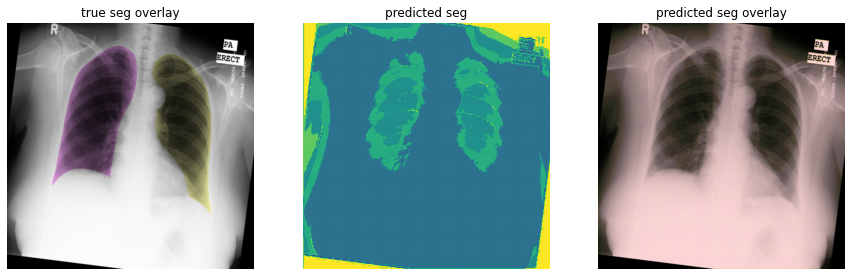

Dice loss: 0.7491559386253357
Critic network confidence in the generated segmentation: 0.8083329200744629
Associated BCE loss: 1.651995062828064
Critic network confidence in the ground truth segmentation: 0.703108012676239
Associated BCE loss: 0.3522447645664215


In [19]:
# Try seg_net on a random image.
data_tiem  = random.choice(dataset_train)
preview_seg_net(data_tiem);
preview_critic_net(data_tiem);

# Training

## Pretraining seg net alone

In [28]:
seg_net.to('cuda')

dataloader_train = monai.data.DataLoader(
    dataset_train,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

dataloader_valid = monai.data.DataLoader(
    dataset_valid,
    batch_size=32,
    num_workers=8,
    shuffle=False
)

learning_rate = 1e-2
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

max_epochs = 30
training_losses = [] 
validation_losses = []

for epoch_number in range(max_epochs):
    
    seg_net.train()
    losses = []
    for batch in dataloader_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].to('cuda')

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    
    seg_net.eval()
    losses = []
    with torch.no_grad():
        for batch in dataloader_valid:
            imgs = batch['img'].to('cuda')
            true_segs = batch['seg'].to('cuda')
            predicted_segs = seg_net(imgs)
            loss = dice_loss(predicted_segs, true_segs)
            losses.append(loss.item())
        validation_loss = np.mean(losses)
        
    print(f"Epoch {epoch_number+1}/{max_epochs}\n\ttraining loss: {training_loss}\n\tvalidation loss: {validation_loss}")
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)

Epoch 1/30
	training loss: 0.6002024412155151
	validation loss: 0.6061561107635498
Epoch 2/30
	training loss: 0.6003734916448593
	validation loss: 0.6040834784507751
Epoch 3/30
	training loss: 0.5950476229190826
	validation loss: 0.6020262837409973
Epoch 4/30
	training loss: 0.59123794734478
	validation loss: 0.60002201795578
Epoch 5/30
	training loss: 0.5881795734167099
	validation loss: 0.5973507761955261
Epoch 6/30
	training loss: 0.5912085324525833
	validation loss: 0.5952684283256531
Epoch 7/30
	training loss: 0.5824712514877319
	validation loss: 0.5930184125900269
Epoch 8/30
	training loss: 0.5842779576778412
	validation loss: 0.589997410774231
Epoch 9/30
	training loss: 0.5753825902938843
	validation loss: 0.5861501097679138
Epoch 10/30
	training loss: 0.5695618689060211
	validation loss: 0.5778094530105591
Epoch 11/30
	training loss: 0.5572494268417358
	validation loss: 0.5118727087974548
Epoch 12/30
	training loss: 0.5539638996124268
	validation loss: 0.483993798494339
Epoch 1

In [29]:
del imgs, true_segs, predicted_segs, loss
torch.cuda.empty_cache()

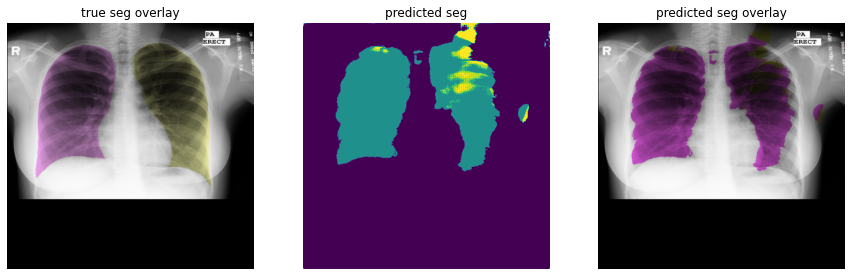

<Figure size 360x360 with 0 Axes>

Dice loss: 0.3678060472011566


In [30]:
preview_seg_net(random.choice(dataset_valid))

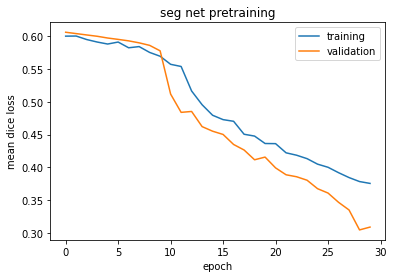

In [31]:
plt.plot(training_losses, label="training")
plt.plot(validation_losses, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean dice loss')
plt.title('seg net pretraining')
plt.savefig('seg_net_pretraining_losses.png')
plt.show()

## Alternate training with critic network

In [22]:
def swap_training(network_to_train, network_to_not_train):
    """
        Switch out of training one network and into training another
    """

    for param in network_to_not_train.parameters():
        param.requires_grad = False
    
    for param in network_to_train.parameters():
        param.requires_grad = True
        
    network_to_not_train.eval()
    network_to_train.train()

In [ ]:
seg_net.to('cuda')
critic_net.to('cuda')

dataloader_train = monai.data.DataLoader(
    dataset_train,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

dataloader_valid = monai.data.DataLoader(
    dataset_valid,
    batch_size=64,
    num_workers=8,
    shuffle=False
)

lambda0 = 0.0001 # How much weight to give to critic score when training seg_net

learning_rate_seg_net = 1e-3
optimizer_seg_net = torch.optim.Adam(seg_net.parameters(), learning_rate_seg_net)
training_losses_seg_net = [] 
validation_losses_seg_net = []

learning_rate_critic_net = 1e-6
optimizer_critic_net = torch.optim.SGD(critic_net.parameters(), learning_rate_critic_net)
training_losses_critic_net = [] 
validation_losses_critic_net = []



max_epochs = 100

for epoch_number in range(max_epochs):
    
    # --------------------------------
    #          seg train
    # --------------------------------
    
    swap_training(seg_net, critic_net)
    losses = []
    for batch in dataloader_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].to('cuda')

        optimizer_seg_net.zero_grad()
        predicted_segs = seg_net(imgs)
        critic_score = critic_net(predicted_segs)
        loss = dice_loss(predicted_segs, true_segs) +\
               lambda0 * bce_loss_logits(critic_score,torch.ones_like(critic_score))
        loss.backward()
        optimizer_seg_net.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    print(f"Epoch {epoch_number+1}/{max_epochs}\n\tseg training loss: {training_loss}")
    training_losses_seg_net.append([epoch_number, training_loss])
    
    
    # --------------------------------
    #          seg val
    # --------------------------------
    
    if (epoch_number%5 == 0):
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_valid:
                imgs = batch['img'].to('cuda')
                true_segs = batch['seg'].to('cuda')
                predicted_segs = seg_net(imgs)
                critic_score = critic_net(predicted_segs)
                loss = dice_loss(predicted_segs, true_segs) +\
                       lambda0 * bce_loss_logits(critic_score,torch.ones_like(critic_score))
                losses.append(loss.item())
            validation_loss = np.mean(losses)
        
        print(f"\tseg validation loss: {validation_loss}")
        validation_losses_seg_net.append([epoch_number, validation_loss])
    
    # --- clean up ---
    del imgs, true_segs, predicted_segs, critic_score, loss
    torch.cuda.empty_cache()
    
    
    # --- Preview ---
    if (epoch_number%5 == 0):
        preview_seg_net(dataset_valid[17], figsize=(6,6), print_loss=False);
    
    
    
    # --------------------------------
    #         critic train
    # --------------------------------

    
    swap_training(critic_net, seg_net)
    losses = []
    for batch in dataloader_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].float().to('cuda')
        
        optimizer_critic_net.zero_grad()
        predicted_segs = seg_net(imgs)
        critic_generated_segs = critic_net(predicted_segs)
        critic_real_segs = critic_net(true_segs)
        loss = bce_loss_logits(critic_generated_segs, torch.zeros_like(critic_generated_segs)) +\
               bce_loss_logits(critic_real_segs, torch.ones_like(critic_real_segs))
        loss.backward()
        optimizer_critic_net.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    print(f"\tcritic training loss: {training_loss}")
    training_losses_critic_net.append([epoch_number, training_loss])

    # --------------------------------
    #         critic val
    # --------------------------------
    
    if (epoch_number%5 == 0):
        critic_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_valid:
                imgs = batch['img'].to('cuda')
                true_segs = batch['seg'].float().to('cuda')
                predicted_segs = seg_net(imgs)
                critic_generated_segs = critic_net(predicted_segs)
                critic_real_segs = critic_net(true_segs)
                loss = bce_loss_logits(critic_generated_segs, torch.zeros_like(critic_generated_segs)) +\
                       bce_loss_logits(critic_real_segs, torch.ones_like(critic_real_segs))
                losses.append(loss.item())
            validation_loss = np.mean(losses)

        print(f"\tcritic validation loss: {validation_loss}")
        validation_losses_critic_net.append([epoch_number, validation_loss])
    
    
    del imgs, true_segs, predicted_segs, critic_generated_segs, critic_real_segs, loss
    torch.cuda.empty_cache()
    

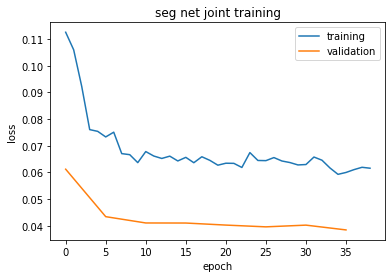

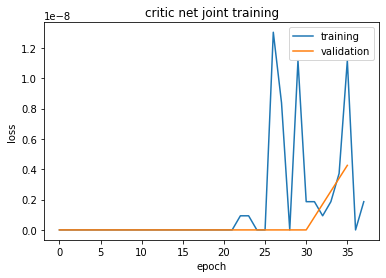

In [65]:
def plot_against_epoch_numbers(epoch_value_pairs, label):
    array = np.array(epoch_value_pairs)
    plt.plot(array[:,0], array[:,1], label=label)

plot_against_epoch_numbers(training_losses_seg_net, label="training")
plot_against_epoch_numbers(validation_losses_seg_net, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('seg net joint training')
plt.savefig('seg_net_losses.png')
plt.show()

plot_against_epoch_numbers(training_losses_critic_net, label="training")
plot_against_epoch_numbers(validation_losses_critic_net, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('critic net joint training')
plt.savefig('critic_net_losses.png')
plt.show()

In [29]:
# CHECKPOINT CELL; SAVE
# torch.save(seg_net.state_dict(),'seg_net5.pth')
# torch.save(critic_net.state_dict(),'critic_net5.pth')

In [20]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net5.pth'))
# critic_net.load_state_dict(torch.load('critic_net5.pth'))

<All keys matched successfully>

0


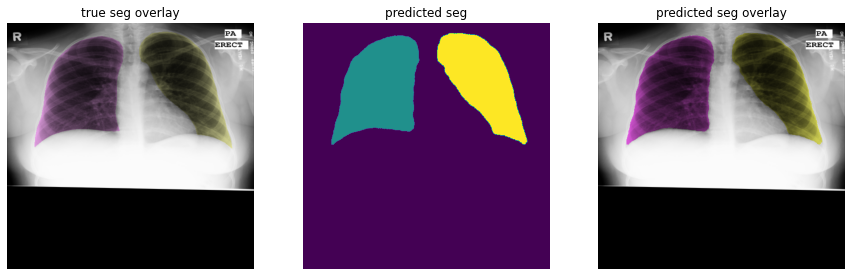

Dice loss: 0.015210330486297607
Critic network confidence in the generated segmentation: 5.177895872482408e-13
Associated BCE loss: 0.0
Critic network confidence in the ground truth segmentation: 1.0
Associated BCE loss: 0.0


In [95]:
#Try both networks on a random validation image
data_item_index  = random.choice(range(len(dataset_valid)))
print(data_item_index)
data_item = dataset_valid[data_item_index]
with torch.no_grad():
    preview_seg_net(data_item);
    preview_critic_net(data_item);

In [ ]:
# In case you want to start with a decent pretrained seg net:
# seg_net.load_state_dict(torch.load('seg_net3.pth'))

## Joint training approach

In [48]:
def set_requires_grad(net, requires_grad : bool):
    for param in net.parameters():
        param.requires_grad = requires_grad

Epoch 1/100
	seg training loss: 0.0789627879858017
	crt training loss: 0.5239235992942538
	seg validation loss: 0.03892828896641731; dice only: 0.03870401903986931
	critic validation loss: 0.42093175649642944


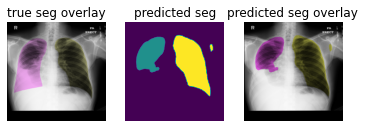

Epoch 2/100
	seg training loss: 0.07226022545780454
	crt training loss: 0.5200523350919996
Epoch 3/100
	seg training loss: 0.07063588180712291
	crt training loss: 0.5086823659283775
Epoch 4/100
	seg training loss: 0.0656805086348738
	crt training loss: 0.4925352952310017
Epoch 5/100
	seg training loss: 0.06599705346993037
	crt training loss: 0.4868300216538565
Epoch 6/100
	seg training loss: 0.06389506799834115
	crt training loss: 0.4733464462416513
	seg validation loss: 0.03027007356286049; dice only: 0.030032623559236526
	critic validation loss: 0.398053914308548


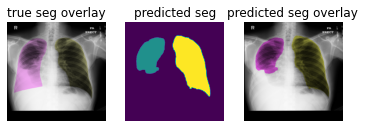

KeyboardInterrupt: 

In [199]:
seg_net.to('cuda')
critic_net.to('cuda')

set_requires_grad(seg_net, True)
set_requires_grad(critic_net, True)

dataloader_train = monai.data.DataLoader(
    dataset_train,
    batch_size=16,
    num_workers=8,
    shuffle=True
)

dataloader_valid = monai.data.DataLoader(
    dataset_valid,
    batch_size=64,
    num_workers=8,
    shuffle=False
)

lambda0 = 0.0001 # How much weight to give to critic score when training seg_net

learning_rate_seg_net = 1e-3
optimizer_seg_net = torch.optim.Adam(seg_net.parameters(), learning_rate_seg_net)
training_losses_seg_net = [] 
validation_losses_seg_net = []

learning_rate_critic_net = 1e-6
optimizer_critic_net = torch.optim.SGD(critic_net.parameters(), learning_rate_critic_net)
training_losses_critic_net = [] 
validation_losses_critic_net = []



max_epochs = 100

for epoch_number in range(max_epochs):
    
    # --------------------------------
    #          train both
    # --------------------------------
    
    seg_net.train()
    critic_net.train()
    seg_losses = []
    critic_losses = []
    for batch in dataloader_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].float().to('cuda')
        
        optimizer_seg_net.zero_grad()
        set_requires_grad(seg_net, True)
        
        predicted_segs = seg_net(imgs)
        critic_generated_segs = critic_net(predicted_segs)
        seg_loss = dice_loss(predicted_segs, true_segs) +\
                   lambda0 * bce_loss_logits(critic_generated_segs,torch.ones_like(critic_generated_segs.detach()))
        
        seg_loss.backward(retain_graph=True)
        set_requires_grad(seg_net, False)
        optimizer_critic_net.zero_grad()
        
        critic_real_segs = critic_net(true_segs)
        critic_generated_segs_loss = bce_loss_logits(
            critic_generated_segs,
            torch.zeros_like(critic_generated_segs)
        )
        critic_real_segs_loss = bce_loss_logits(
            critic_real_segs,
            torch.ones_like(critic_real_segs)
        )
        
        critic_generated_segs_loss.backward()
        critic_real_segs_loss.backward()

        optimizer_seg_net.step()
        optimizer_critic_net.step()

        seg_losses.append(seg_loss.item())
        critic_losses.append(critic_real_segs_loss.item() + critic_generated_segs_loss.item())
    
    seg_training_loss = np.mean(seg_losses)
    critic_training_loss = np.mean(critic_losses)
    print(f"Epoch {epoch_number+1}/{max_epochs}")
    print(f"\tseg training loss: {seg_training_loss}")
    print(f"\tcrt training loss: {critic_training_loss}")
    training_losses_seg_net.append([epoch_number, seg_training_loss])
    training_losses_critic_net.append([epoch_number, critic_training_loss])
    
    del imgs, true_segs, predicted_segs, critic_generated_segs, seg_loss,\
        critic_real_segs, critic_real_segs_loss, critic_generated_segs_loss
    torch.cuda.empty_cache()
    
    
    # Switch to evaluation mode for validation
    seg_net.eval()
    critic_net.eval()
    
    # --------------------------------
    #          seg val
    # --------------------------------
    
    if (epoch_number%5 == 0):
        
        losses = []
        losses_dice_only = []
        with torch.no_grad():
            for batch in dataloader_valid:
                imgs = batch['img'].to('cuda')
                true_segs = batch['seg'].to('cuda')
                predicted_segs = seg_net(imgs)
                critic_score = critic_net(predicted_segs)
                seg_similarity_loss = dice_loss(predicted_segs, true_segs)
                loss = seg_similarity_loss +\
                       lambda0 * bce_loss_logits(critic_score,torch.ones_like(critic_score))
                losses.append(loss.item())
                losses_dice_only.append(seg_similarity_loss.item())
            validation_loss = np.mean(losses)
            validation_loss_dice_only = np.mean(losses_dice_only)
        
        print(f"\tseg validation loss: {validation_loss}; dice only: {validation_loss_dice_only}")
        validation_losses_seg_net.append([epoch_number, validation_loss])
    
        # --- clean up ---
        del imgs, true_segs, predicted_segs, critic_score, loss, seg_similarity_loss
        torch.cuda.empty_cache()
    
    

    # --------------------------------
    #         critic val
    # --------------------------------
    
    if (epoch_number%5 == 0):
        critic_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_valid:
                imgs = batch['img'].to('cuda')
                true_segs = batch['seg'].float().to('cuda')
                predicted_segs = seg_net(imgs)
                critic_generated_segs = critic_net(predicted_segs)
                critic_real_segs = critic_net(true_segs)
                loss = bce_loss_logits(critic_generated_segs, torch.zeros_like(critic_generated_segs)) +\
                       bce_loss_logits(critic_real_segs, torch.ones_like(critic_real_segs))
                losses.append(loss.item())
            validation_loss = np.mean(losses)

        print(f"\tcritic validation loss: {validation_loss}")
        validation_losses_critic_net.append([epoch_number, validation_loss])

    
        del imgs, true_segs, predicted_segs, critic_generated_segs, critic_real_segs, loss
        torch.cuda.empty_cache()
    
    
    # --- Preview ---
    if (epoch_number%5 == 0):
        preview_seg_net(dataset_valid[18], figsize=(6,6), print_loss=False);
        
    # STOP if the critic network has gotten too good; this is a failure mode of adversarial training
    if critic_training_loss < 0.1:
        print("""Critic network training loss is low; stopping.
              You could continue with different learning rates and thresholds""")

In [154]:
# CHECKPOINT CELL; SAVE
torch.save(seg_net.state_dict(),'seg_net6.pth')
torch.save(critic_net.state_dict(),'critic_net6.pth')

In [ ]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net6.pth'))
# critic_net.load_state_dict(torch.load('critic_net6.pth'))

17


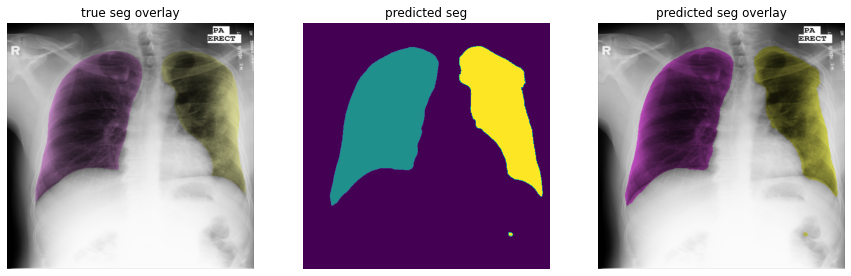

Dice loss: 0.03996390104293823
Critic network confidence in the generated segmentation: 0.36947500705718994
Associated BCE loss: 0.461202472448349
Critic network confidence in the ground truth segmentation: 0.7169675230979919
Associated BCE loss: 0.33272475004196167


In [195]:
#Try both networks on a random validation image
data_item_index  = random.choice(range(len(dataset_valid)))
print(data_item_index)
data_item = dataset_valid[data_item_index]
with torch.no_grad():
    preview_seg_net(data_item);
    preview_critic_net(data_item);

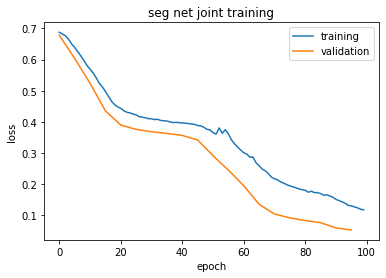

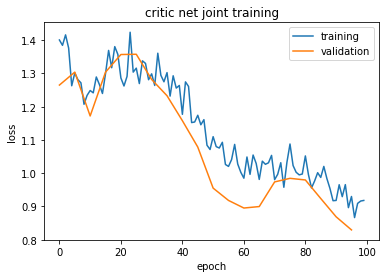

In [55]:
def plot_against_epoch_numbers(epoch_value_pairs, label):
    array = np.array(epoch_value_pairs)
    plt.plot(array[:,0], array[:,1], label=label)

plot_against_epoch_numbers(training_losses_seg_net, label="training")
plot_against_epoch_numbers(validation_losses_seg_net, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('seg net joint training')
plt.savefig('seg_net_losses.png')
plt.show()

plot_against_epoch_numbers(training_losses_critic_net, label="training")
plot_against_epoch_numbers(validation_losses_critic_net, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('critic net joint training')
plt.savefig('critic_net_losses.png')
plt.show()